Coherence Time 1 : 0.023873241463784303 s
Coherence Time: 24 ms
Coherence Time 2: 0.13333333333333333 s
Coherence Time: 133 ms


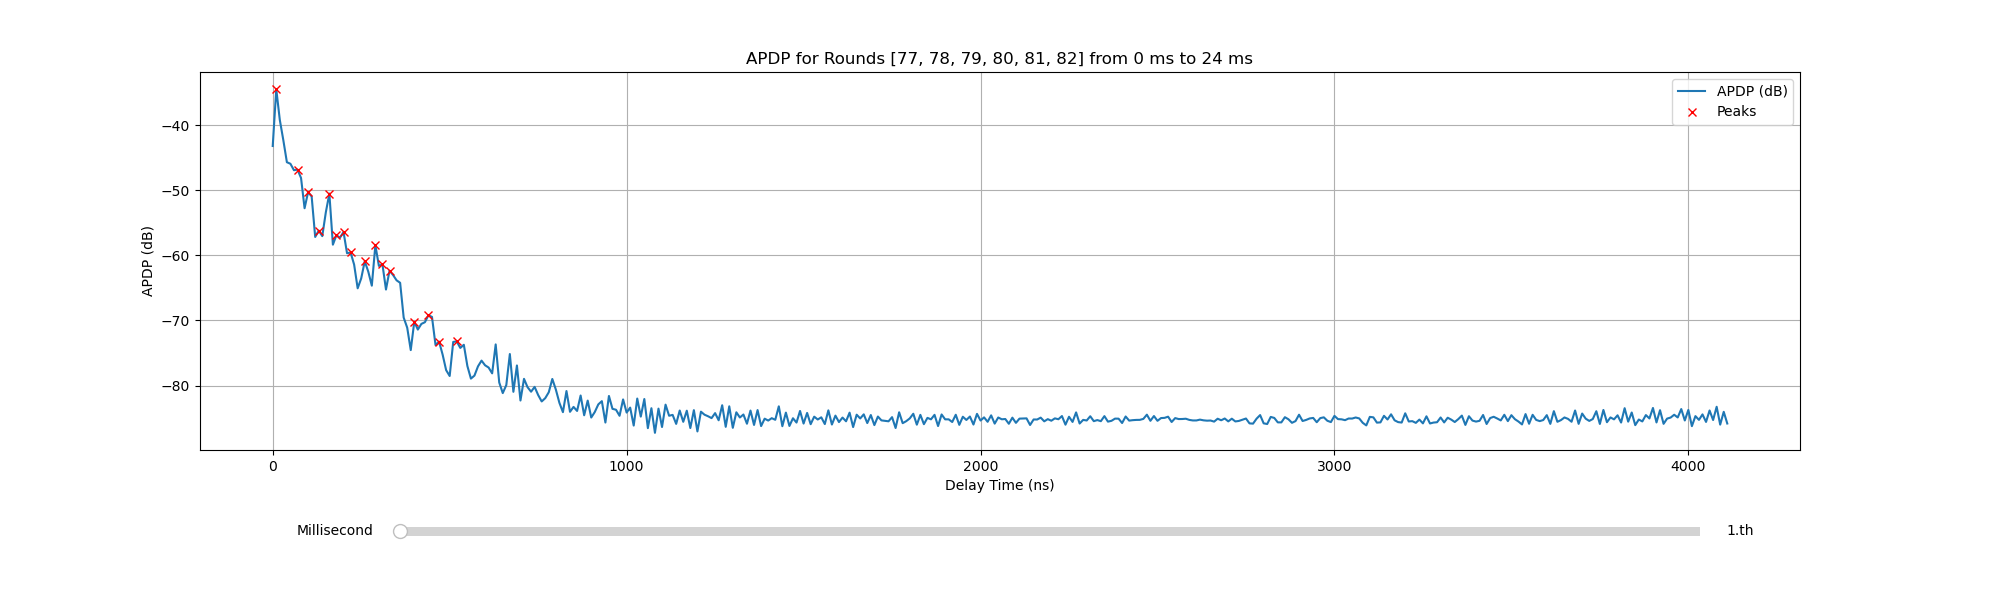

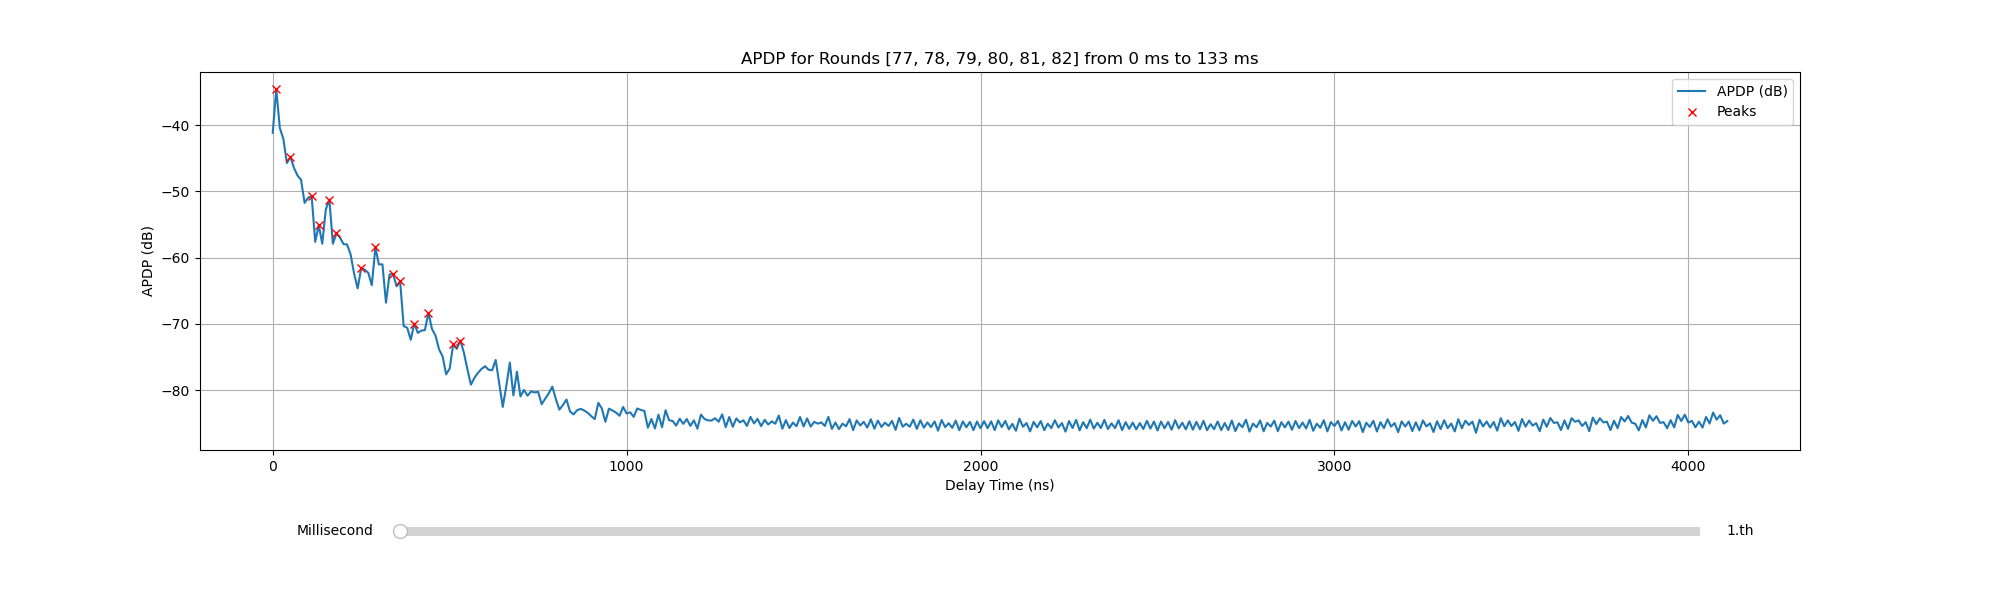

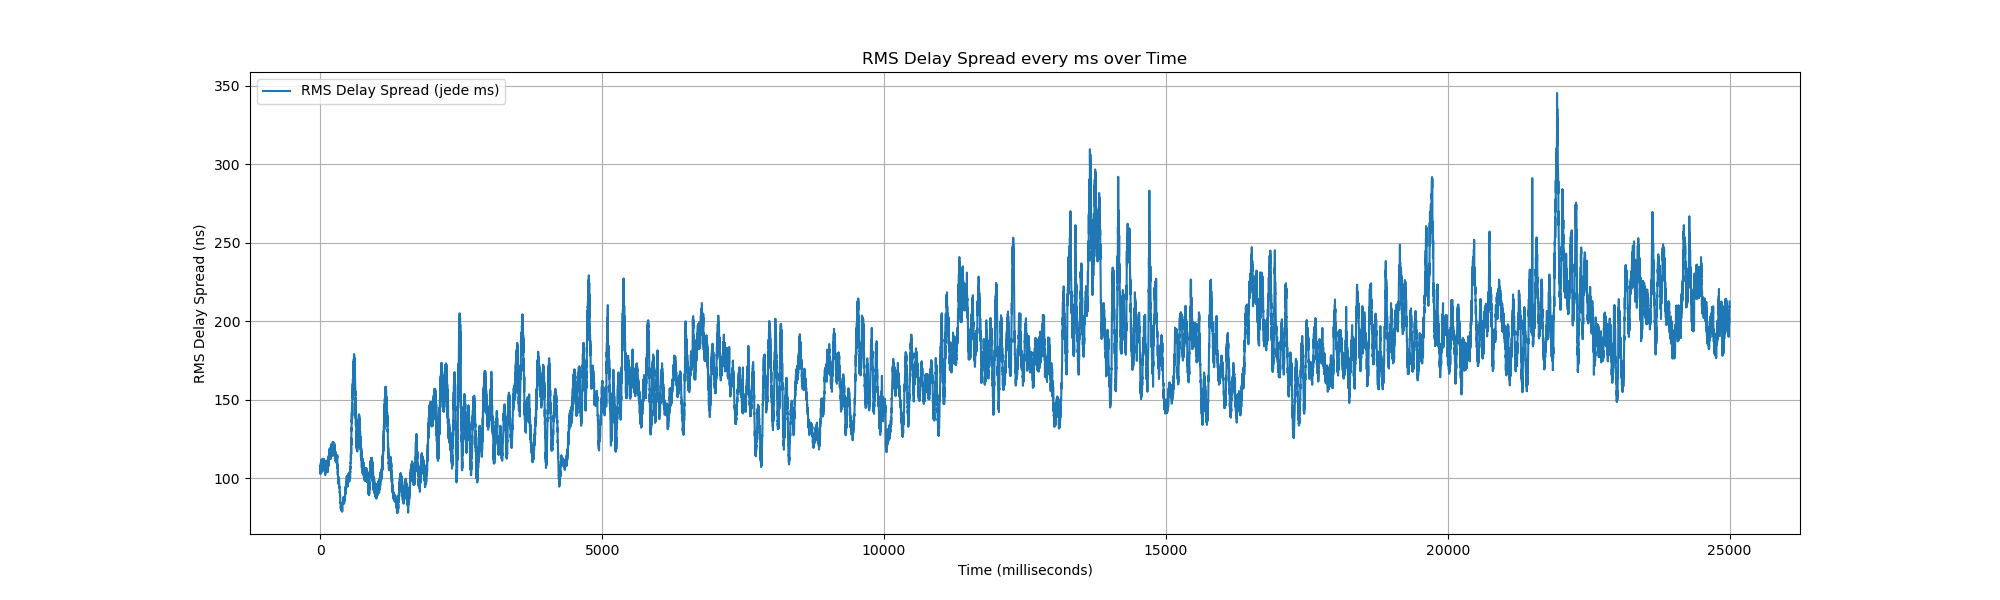

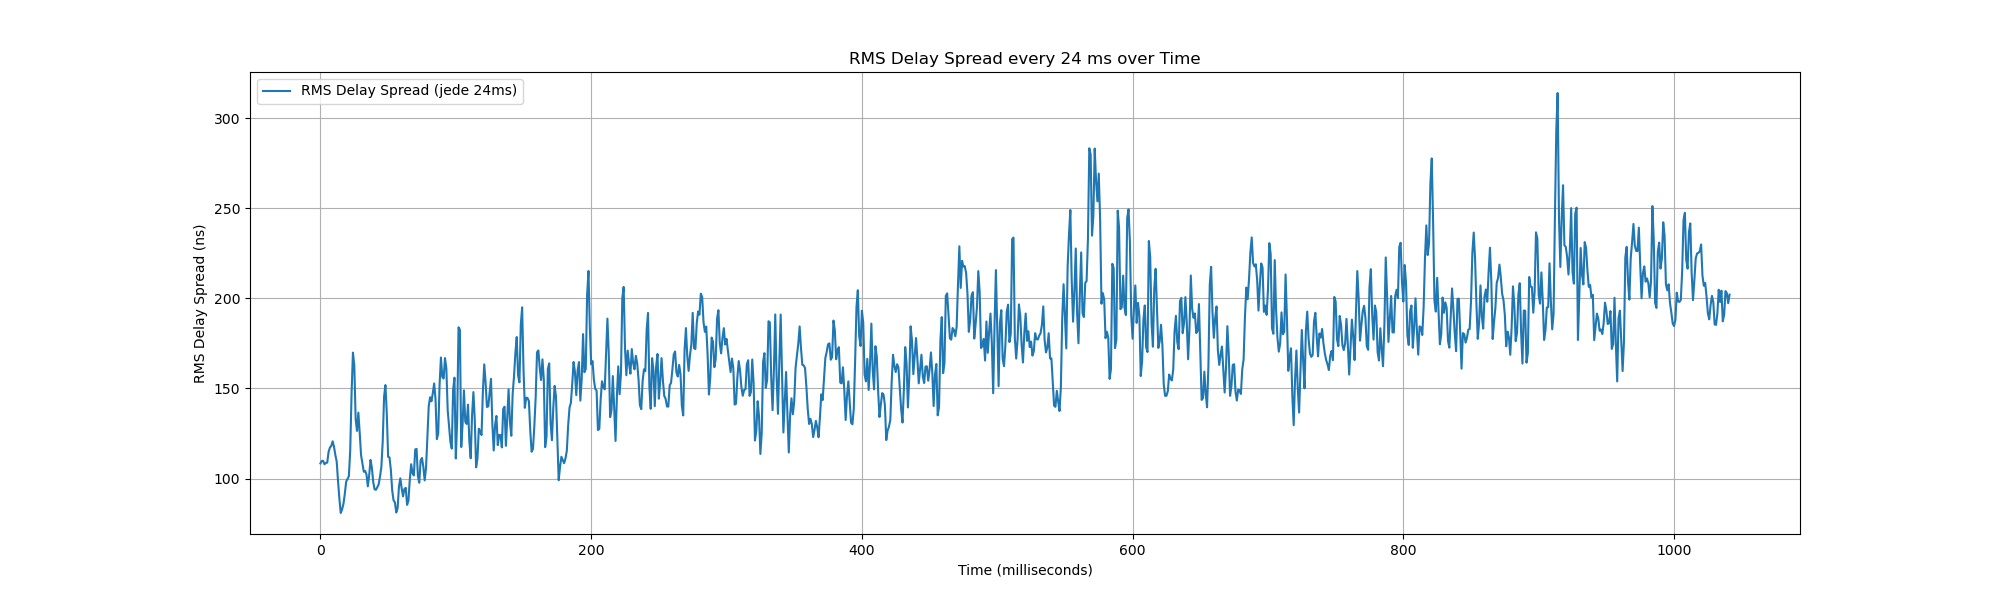

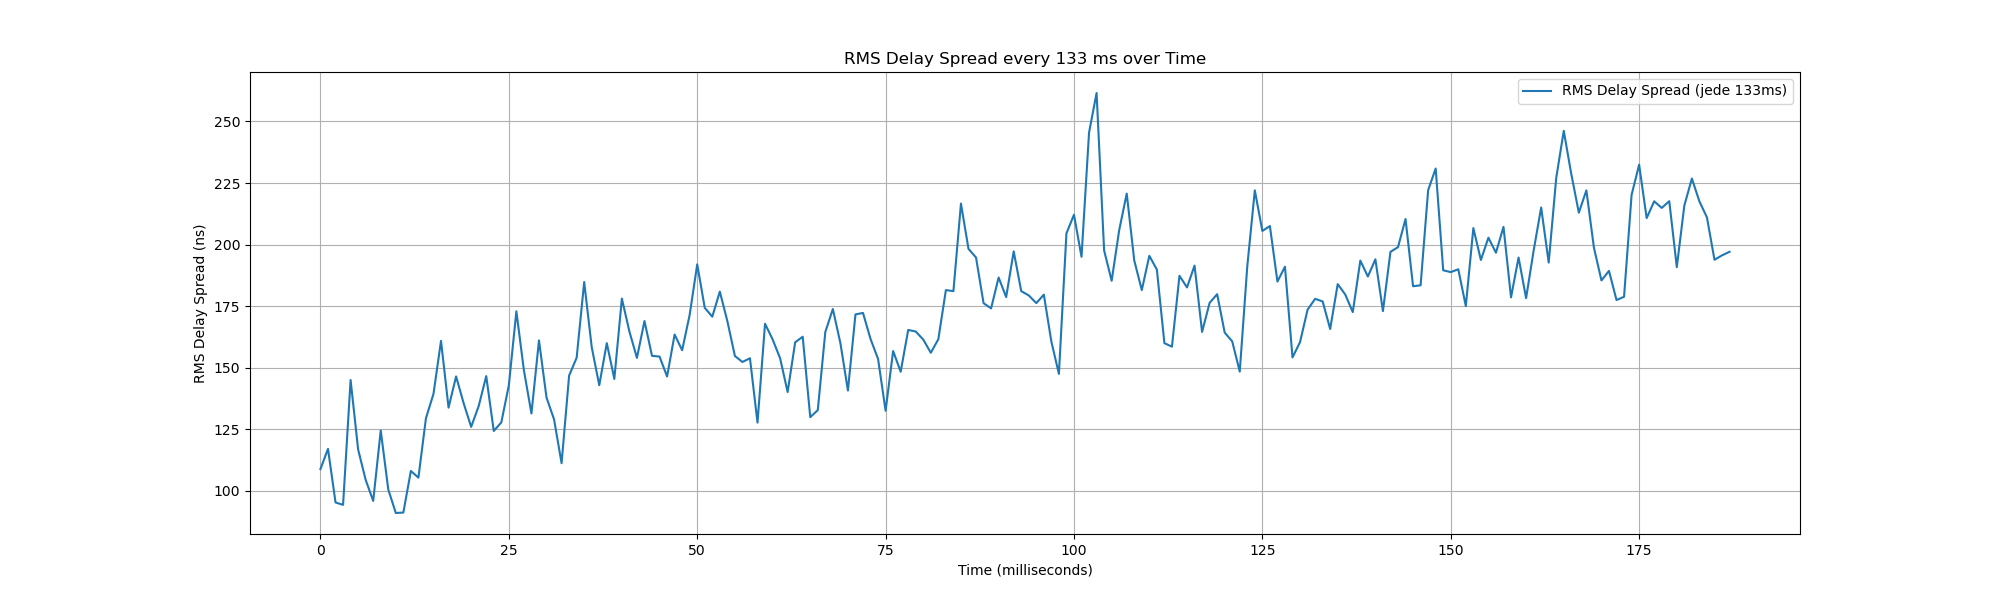

RMSE between every ms and every 24ms:7.119209630724738e-09
RMSE between every ms and every 133ms:1.6093210927037894e-08
absolute Error between every ms and every 24ms :[ 1.62901196e-09  5.68287797e-09  1.24069434e-11 ... -7.54236057e-09
 -6.93880276e-09 -1.05208315e-08]


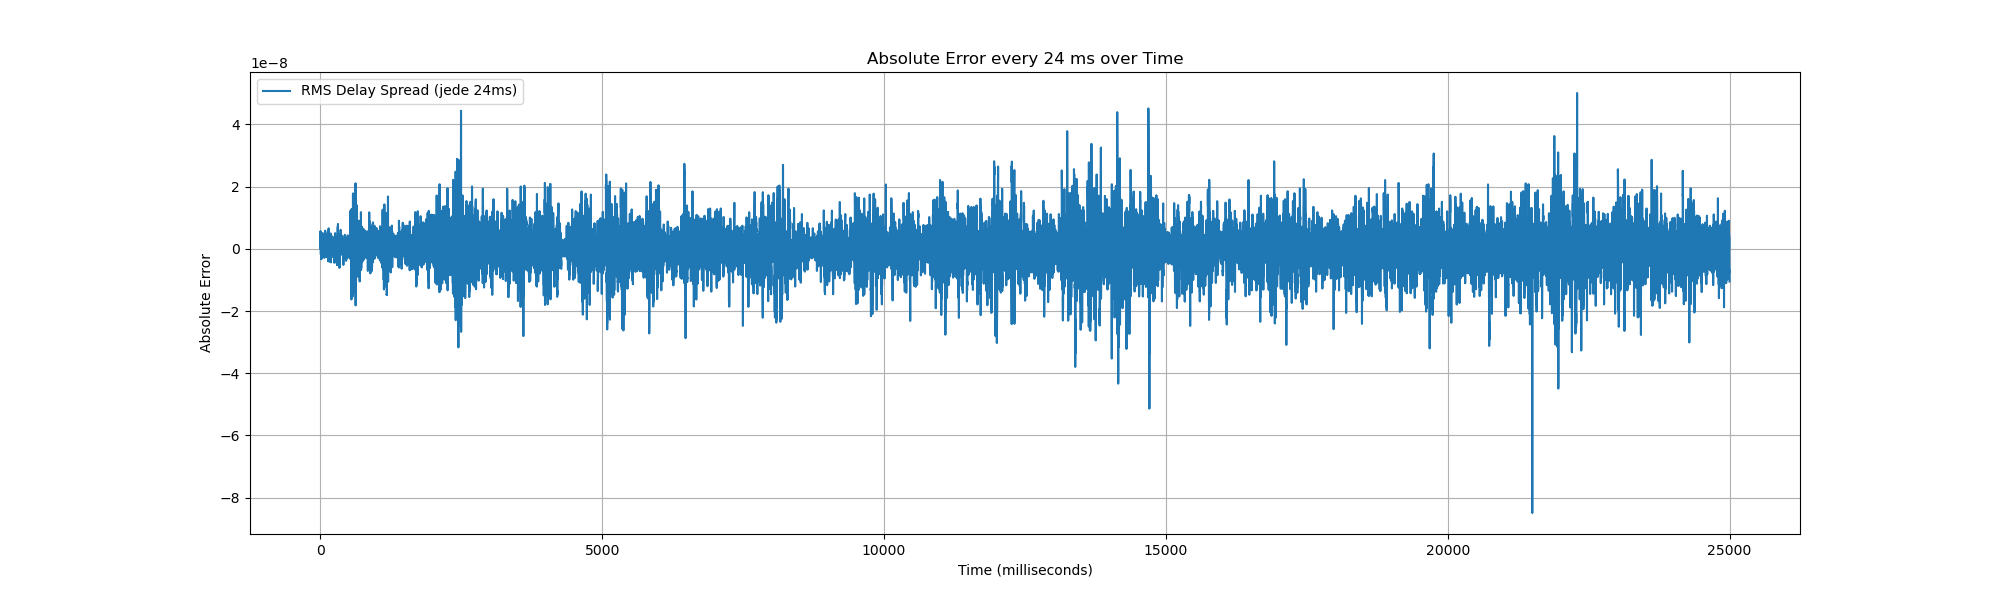

absolute Error between every ms and every 133ms :[ 2.01594485e-09  6.06981086e-09  3.99339836e-10 ... -1.25343800e-08
 -1.19308222e-08 -1.55128509e-08]


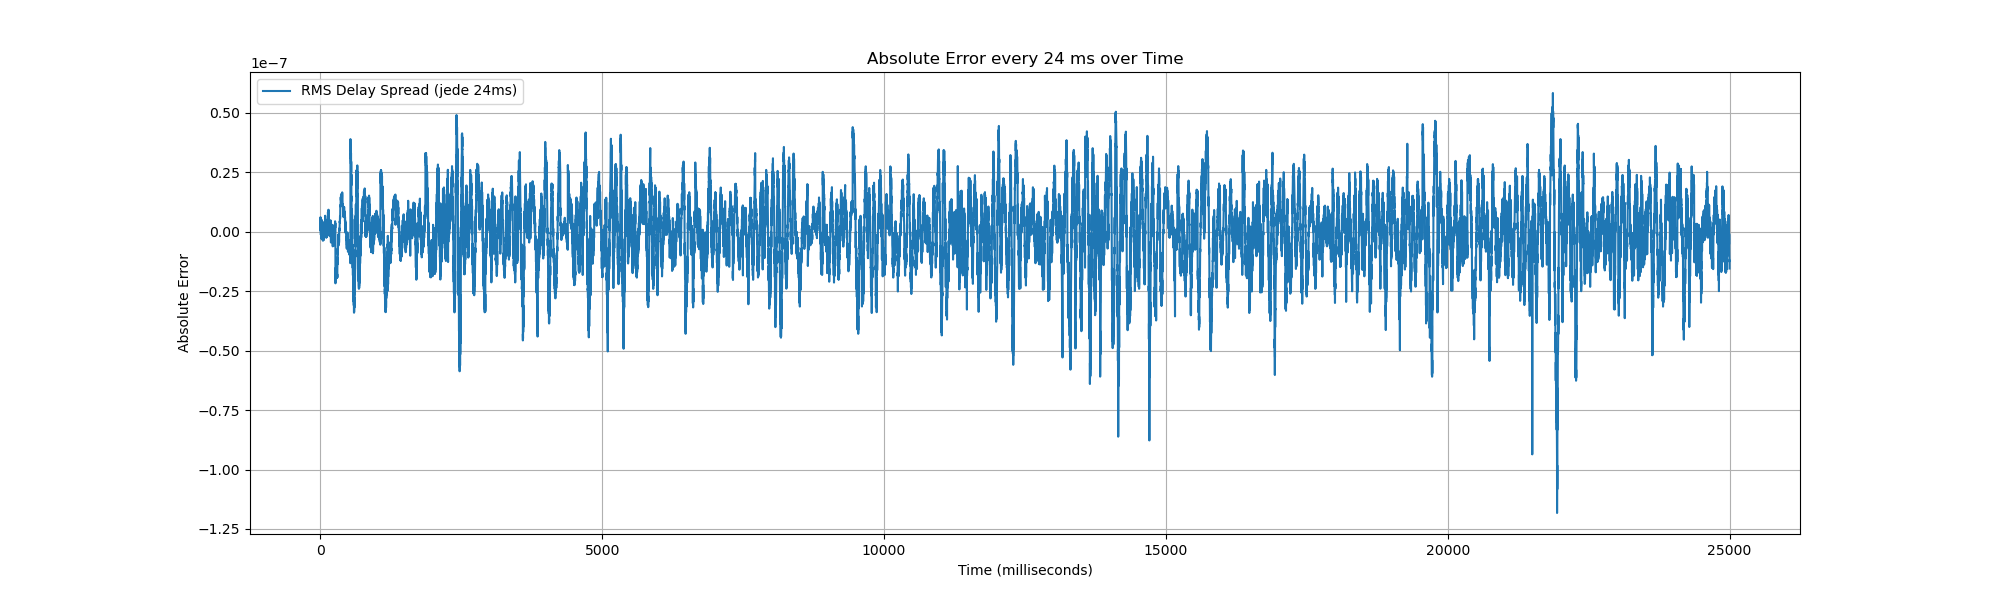

In [6]:
#%%

%matplotlib widget
from sklearn.metrics import mean_squared_error
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import math
from scipy.signal import find_peaks
from matplotlib.widgets import Slider
import pickle
from ipywidgets import interact


# Informationen
load_path = "/media/student/SEW/Bearbeitet_Data/Rx1/Tag1_Scenario1_AGVHorizontal/"
#load_path = "/media/student/SEW/Bearbeitet_Data/Rx1/Tag1_Scenario1_Langzeitmessungen/"

#wechselbar
#round_numbers = [22]#,26,30,35,38
round_numbers = [77,78,79,80,81,82]
seconds = []
#RF_index = 0
#APDP_index = 1


for filenames in os.listdir(load_path):
  for round_number in round_numbers:
      #print(f"all file:{filenames}")
      if filenames.startswith(f"Round_{round_number}_AP_1_RF_1_Sec_") and filenames.endswith(".mat"):
        #print(filenames)
        r = int (filenames.split("_")[7].replace(".mat",""))
        seconds.append((round_number,r))

        #ordnen wie 1,2,3,...
seconds.sort(key=lambda x: (x[0], x[1]))
#print (f"second ist {seconds}")


# die Daten für bestimmte Round und Zeit herunterladen

data = []


for second in range(1,26):
  data_1 = []
  for round_number in round_numbers:
    
    filename = f"Round_{round_number}_AP_1_RF_0_Sec_{second}.mat"
    full_filename = os.path.join(load_path, filename)
    if os.path.exists(full_filename):
      mat = scipy.io.loadmat(full_filename)
      cirs_data = mat["cirs"]
      #print(f"cir shape : {cirs_data.shape}") 
      data_1.append((np.abs(cirs_data[28:440,:])**2))
      
    else:
      print(f"File {filename} not found.")
    
  data.append(data_1)
  
data = np.array(data) 
#print (f"data shape: {data.shape}")
data = np.concatenate(data, axis=2)
#print (f"data shape: {data.shape}")


#coherence Time
c_licht = 3e8
v = 0.6
f_c = 3.75e9  #Hz
T_c_1 = (9 * c_licht) / (16 * math.pi *f_c * v )
print(f"Coherence Time 1 : {T_c_1} s")
co_time_1 = round(T_c_1 * 1e3) 
print(f"Coherence Time: {co_time_1} ms")

#Doppler shift
f_d =  v * f_c / c_licht
T_c_2 =  1 / f_d
print(f"Coherence Time 2: {T_c_2} s")
co_time_2 = round(T_c_2 * 1e3) 
print(f"Coherence Time: {co_time_2} ms")

# Sampling interval (in seconds)
sampling_interval = 10e-9
num_delays = data.shape[1]
delays = np.arange(num_delays) * sampling_interval
delays = delays - 10e-9
#print(num_delays)
#print("Initial shape of delays:", delays_1.shape)
num_milliseconds = data.shape[2]
#print(f"num_milliseconds:{data.shape[2]}")
number_1 = int(np.ceil(num_milliseconds / co_time_1))
number_2 =  int(np.ceil(num_milliseconds / co_time_2))
#print(f"Number of samples for coherence time 1: {number_1}")

#Parameters

APDP_ms = []
#APDP_db_all = []
all_peaks_all = []
all_peaks_all_1 = []
all_peaks_all_2 = []


new_APDP_1 =  np.zeros(( number_1 * co_time_1 ,num_delays))
new_APDP_2 =  np.zeros(( number_2 * co_time_2 ,num_delays))
rms_delay_spread_array = np.zeros(num_milliseconds)
rms_delay_spread_1_array = np.zeros(number_1)
rms_delay_spread_2_array = np.zeros(number_2)
co_bandwidth = np.zeros(num_milliseconds)
co_bandwidth_1 = np.zeros(number_1)
co_bandwidth_2 = np.zeros(number_2)
all_peaks = np.zeros(num_delays*num_milliseconds)

def  find_peaks_in_data(data,co_time):
  all_peaks_all = []
  for index in range(len(data)):
    current_segment = data[index]
    max_index = np.argmax(current_segment)
    APDP_db_after_max = current_segment[max_index +1:] 
                    
    min_height = np.max(data[:,200:]) + 3
    peaks, peak_heights = find_peaks(APDP_db_after_max, height = min_height, prominence = (0.1, None))
    peaks = peaks + max_index +1
    all_peaks = np.append(peaks, max_index)
    all_peaks = np.sort(all_peaks)
            
    all_peaks_all.append(all_peaks)
    #print(all_peaks.shape)

  filename = f'all_peaks_for_every_{co_time}.pkl'
  
  with open(filename, 'wb') as f:
      pickle.dump(all_peaks_all, f)

  return  all_peaks_all

APDP_db_all = np.load('Power_of_APDP_of_every_ms.npy')
all_peaks_all =  find_peaks_in_data(APDP_db_all,1)

#Figure

def plot_apdp_with_slider(data, peaks_all, ms_delay, co_time, round_numbers):
    # Create figure and axis
    
    fig, ax = plt.subplots(figsize=(20, 6))
    plt.subplots_adjust(left=0.1, bottom=0.25)
    
    # Initial plot
    current_index = 0
    #APDP_db = data[current_index]
    peaks = peaks_all[current_index]
    
    # Plot the APDP (dB) line and peaks
    line, = ax.plot(ms_delay * 1e9, data[current_index], label='APDP (dB)')
    peaks_plot, = ax.plot(ms_delay[peaks] * 1e9, data[current_index, peaks], 'rx', label='Peaks')

    # Set labels and title
    ax.set_xlabel("Delay Time (ns)")
    ax.set_ylabel("APDP (dB)")
    ax.set_title(f"APDP for Rounds {round_numbers} from {current_index * co_time} ms to {current_index * co_time + co_time} ms")
    ax.legend()
    ax.grid(True)

    # Create a slider
    ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
    slider = Slider(ax_slider, 'Millisecond', 1, len(data) , valinit=1, valfmt='%d.th')
    
    # Update function for the slider
    def update(val):
        index = int(slider.val) - 1
        #APDP_db = data[index]
        peaks = peaks_all[index]
        
        # Update the plot data
        line.set_ydata(data[index, :])
        peaks_plot.set_xdata(ms_delay[peaks] * 1e9)
        peaks_plot.set_ydata(data[index, peaks])
        
        # Rescale and redraw
        
        ax.set_title(f"APDP for Rounds {round_numbers} from {index * co_time} ms to {index * co_time + co_time} ms")
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw_idle()

    # Connect slider to the update function
    slider.on_changed(update)
    plt.show()
    
def calculate_rmse(hist, val):
    rmse = np.sqrt(mean_squared_error(hist, val))
    return rmse

def interrupt (vorne,co_time,number):
    new_array = np.zeros(num_milliseconds)
    for i in range(number):
        start_idx = i * co_time
        end_idx = min ((i+1)*co_time,num_milliseconds)
        new_array [start_idx: end_idx] = vorne[i] 

    return new_array

def abs_error (val1, val2):
    error = np.zeros(num_milliseconds)
    for i in range(num_milliseconds):
            error = val2 - val1

    return error

    

APDP_db_all_1 = np.load('Power_of_APDP_of_every_24.npy')
APDP_db_all_2 = np.load('Power_of_APDP_of_every_133.npy')
ms_final_1 = np.load('ms_of_every_24.npy')
ms_final_2 = np.load('ms_of_every_133.npy')
with open('all_peaks_for_every_24.pkl', 'rb') as file:
    all_peaks_all_1 = pickle.load(file)
with open('all_peaks_for_every_133.pkl', 'rb') as file:
    all_peaks_all_2 = pickle.load(file)


plot_apdp_with_slider(APDP_db_all_1, all_peaks_all_1, ms_final_1, co_time_1, round_numbers)

plot_apdp_with_slider(APDP_db_all_2, all_peaks_all_2, ms_final_2, co_time_2, round_numbers)



rms_delay_spread_array = np.load('rms_delay_spread_of_every_1000_ms.npy')
plt.figure(figsize=(20, 6))
plt.plot(rms_delay_spread_array * 1e9, label='RMS Delay Spread (jede ms)')
plt.xlabel("Time (milliseconds)")
plt.ylabel("RMS Delay Spread (ns)")
plt.title("RMS Delay Spread every ms over Time")
plt.legend()
plt.grid(True)
plt.show()
rms_delay_spread_array_1 = np.load('rms_delay_spread_of_every_24_ms.npy')
#print(f"tpye of rms 1 :{type(rms_delay_spread_array_1)}")
plt.figure(figsize=(20, 6))
plt.plot(rms_delay_spread_array_1 * 1e9, label='RMS Delay Spread (jede 24ms)')
plt.xlabel("Time (milliseconds)")
plt.ylabel("RMS Delay Spread (ns)")
plt.title("RMS Delay Spread every 24 ms over Time")
plt.legend()
plt.grid(True)
plt.show()
rms_delay_spread_array_2 = np.load('rms_delay_spread_of_every_133_ms.npy')
plt.figure(figsize=(20, 6))
plt.plot(rms_delay_spread_array_2 * 1e9, label='RMS Delay Spread (jede 133ms)')
plt.xlabel("Time (milliseconds)")
plt.ylabel("RMS Delay Spread (ns)")
plt.title("RMS Delay Spread every 133 ms over Time")
plt.legend()
plt.grid(True)

plt.show()

#Error analyse
rms_24_interrupt_array = interrupt(rms_delay_spread_array_1,co_time_1,number_1)
#print(f"interrupt : {rms_24_interrupt_array}")
rms_133_interrupt_array = interrupt(rms_delay_spread_array_2,co_time_2,number_2)

RMSE_24 = calculate_rmse(rms_delay_spread_array,rms_24_interrupt_array)
print(f"RMSE between every ms and every 24ms:{RMSE_24}")
RMSE_133 = calculate_rmse(rms_delay_spread_array,rms_133_interrupt_array)
print(f"RMSE between every ms and every 133ms:{RMSE_133}")

abs_error_24 = abs_error(rms_delay_spread_array, rms_24_interrupt_array)
print(f"absolute Error between every ms and every 24ms :{abs_error_24}")
plt.figure(figsize=(20, 6))
plt.plot(abs_error_24, label='RMS Delay Spread (jede 24ms)')
plt.xlabel("Time (milliseconds)")
plt.ylabel("Absolute Error")
plt.title("Absolute Error every 24 ms over Time")
plt.legend()
plt.grid(True)
plt.show()

abs_error_133= abs_error(rms_delay_spread_array, rms_133_interrupt_array)
print(f"absolute Error between every ms and every 133ms :{abs_error_133}")
plt.figure(figsize=(20, 6))
plt.plot(abs_error_133, label='RMS Delay Spread (jede 24ms)')
plt.xlabel("Time (milliseconds)")
plt.ylabel("Absolute Error")
plt.title("Absolute Error every 24 ms over Time")
plt.legend()
plt.grid(True)
plt.show()
